<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_LangGraph_Exercise/blob/main/RAG_Chatbot/rag_chatbot_with_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About

* LangGraph allows you to build chatbot with memory using `MemorySaver`
* Basic Agentic RAG & Chatbot

In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters playwright unstructured
!playwright install
%pip install -U --quiet rank_bm25 faiss-cpu

In [2]:
from google.colab import userdata

# load the environment variables set in colab
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
LANGSMITH_API_KEY = userdata.get('LANGSMITH_API_KEY')

## RAG

#### Retriever

In [3]:
from langchain_community.document_loaders import PlaywrightURLLoader
from langchain_community.vectorstores import Chroma
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool


urls = [
   "https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-3-adding-memory-to-the-chatbot",
]

loader = PlaywrightURLLoader(urls=urls, remove_selectors=["header", "footer"])
docs = await loader.aload()  # returns "Document" type

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs)  # split into chunks with overlap

# choose retriever type based on the number of chunks
chunks_ct = len(doc_splits)
if chunks_ct < 30:
  print(chunks_ct, 'choose vectorstore based retriever')
  # use Vectorstore-backed retriever (the simplest retriever in LangChain)
  vectorstore = Chroma.from_documents(
      documents=doc_splits,
      collection_name="rag-chroma",
      embedding=OpenAIEmbeddings(api_key=OPENAI_API_KEY),
  )
  retriever = vectorstore.as_retriever()
else:
  print(chunks_ct, 'choose ensemble retriever')
  # use emsemble retriever
  # initialize the bm25 retriever and faiss retriever
  bm25_retriever = BM25Retriever.from_texts(
      [doc.page_content for doc in doc_splits], metadatas=[{"source": 1}] * len(doc_splits)
  )
  bm25_retriever.k = 2
  embedding = OpenAIEmbeddings(api_key=OPENAI_API_KEY)
  faiss_vectorstore = FAISS.from_texts(
      [doc.page_content for doc in doc_splits], embedding, metadatas=[{"source": 2}] * len(doc_splits)
  )
  faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 2})
  # initialize the ensemble retriever
  retriever = EnsembleRetriever(
      retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5]
  )

80 choose ensemble retriever


In [4]:
# create a retriever tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_urls",
    "Search and return information about the info in provided URLs.",
)

tools = [retriever_tool]

#### Agent State

In [5]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### Nodes & Edges

In [6]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import tools_condition


model_str = "gpt-4o-mini-2024-07-18"

In [7]:
def grade_documents(state) -> Literal["generate_answer", "rewrite_query"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state
    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, api_key=OPENAI_API_KEY,
                       model=model_str, streaming=True)
    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool  # the output of "prompt" will be passed as the input of "llm_with_tool"

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate_answer"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite_query"

In [8]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state
    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, api_key=OPENAI_API_KEY,
                       streaming=True, model=model_str)
    model = model.bind_tools(tools)  # in this case, tools only have retriever_tool
    response = model.invoke(messages)
    return {"messages": [response]}  # add the response to the existing list


def rewrite_query(state):
    """
    Transform the query to produce a better query.

    Args:
        state (messages): The current state
    Returns:
        dict: The updated state with re-phrased query
    """
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
                    Look at the input and try to reason about the underlying semantic intent or meaning. \n
                    Here is the initial question:
                    \n ------- \n
                    {question}
                    \n ------- \n
                    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, api_key=OPENAI_API_KEY,
                       model=model_str, streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate_answer(state):
    """
    Generate answer

    Args:
        state (messages): The current state
    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE ANSWER---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt",
                      api_key=LANGSMITH_API_KEY)  # from LangChain hub: https://smith.langchain.com/hub/

    # LLM
    llm = ChatOpenAI(model_name=model_str, api_key=OPENAI_API_KEY,
                     temperature=0, streaming=True)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()  # output most likely str

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

#### Graph with Memory

In [9]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite_query", rewrite_query)  # Re-writing the query
workflow.add_node("generate_answer", generate_answer)  # Generating a response after we know the documents are relevant

# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")
# decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    tools_condition,  # decides retrieve or END
    {
        # translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_query", "agent")

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)  # adds memory to chatbot

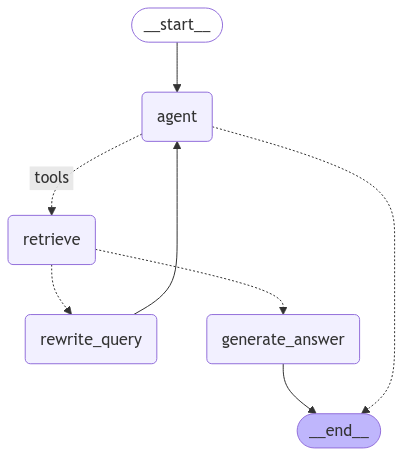

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.errors import GraphRecursionError
from collections import deque


def run_graph(user_input):
  graph_config = {"configurable": {"thread_id": "1"}}
  events = graph.stream(
      {"messages": [("user", user_input)]}, graph_config, stream_mode="values"
    )
  try:
    answer = deque(events, maxlen=1).pop()["messages"][-1]
    return answer
  except:
    return "Didn't get any answer"

In [12]:
user_input = 'What is time travel'
run_graph(user_input)

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE ANSWER---


HumanMessage(content='Time travel, in the context of LangGraph, refers to the ability to "rewind" a chatbot\'s state to a previous point in time, allowing users to explore different outcomes or correct mistakes. This functionality is achieved by fetching a checkpoint using the graph\'s get_state_history method and resuming execution from that saved state. It enhances user interaction by enabling branching paths in conversations and error recovery.', additional_kwargs={}, response_metadata={}, id='4fbf1d7b-b4ce-4dbc-9ca0-88c1d67b1b6f')

In [14]:
user_input = 'How to use it?'
run_graph(user_input)

---CALL AGENT---


AIMessage(content='Using time travel, particularly in the context of science fiction or theoretical physics, can vary widely depending on the framework or narrative being discussed. Here are some general ways time travel is portrayed and how it can be "used" in different contexts:\n\n### 1. **In Science Fiction**\n   - **Time Machines**: Many stories feature devices or machines that allow characters to travel through time. For example, H.G. Wells\' "The Time Machine" describes a device that enables the user to move to any point in time.\n   - **Time Travel Devices**: In movies like "Back to the Future," characters use a modified car (the DeLorean) to travel through time when it reaches a specific speed.\n   - **Magic or Supernatural Means**: Some narratives use magical elements or supernatural abilities to allow characters to travel through time, such as in "Doctor Who" with the TARDIS.\n\n### 2. **In Theoretical Physics**\n   - **Understanding Relativity**: To theoretically "use" time

In [15]:
user_input = 'What is human in the loop?'
run_graph(user_input)

---CALL AGENT---


AIMessage(content='"Human in the loop" (HITL) is a concept used in various fields, particularly in artificial intelligence (AI), machine learning, and automation. It refers to the involvement of human oversight or intervention in processes that are typically automated or driven by algorithms. Here are some key aspects of the human-in-the-loop approach:\n\n### 1. **Definition**\n   - HITL involves integrating human judgment, expertise, or decision-making into automated systems. This can occur at various stages of a process, from data collection and analysis to decision-making and feedback.\n\n### 2. **Applications**\n   - **Machine Learning**: In machine learning, human input is often necessary for tasks such as labeling data, refining algorithms, and validating results. For example, humans may review and correct the outputs of an AI model to improve its accuracy.\n   - **Autonomous Systems**: In autonomous vehicles or drones, human operators may intervene in critical situations to ensu

In [16]:
user_input = 'How to use it?'
run_graph(user_input)

---CALL AGENT---


AIMessage(content='Using the "human in the loop" (HITL) approach involves integrating human oversight and decision-making into automated systems or processes. Here are steps and considerations for effectively implementing HITL in various contexts:\n\n### 1. **Identify the Process**\n   - Determine which processes or systems would benefit from human oversight. This could include areas where decisions are complex, require ethical considerations, or where accuracy is critical.\n\n### 2. **Define Roles and Responsibilities**\n   - Clearly outline the roles of human participants in the process. Define what tasks they will perform, such as reviewing outputs, providing feedback, or making final decisions.\n\n### 3. **Integrate Human Feedback Mechanisms**\n   - Develop systems that allow humans to provide input easily. This could involve:\n     - **Review Interfaces**: Create user-friendly interfaces for humans to review and approve or reject automated outputs.\n     - **Feedback Loops**: Impl